In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold,cross_val_score
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('House_Rent_Dataset.csv')
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
data.shape

(4746, 12)

In [4]:
data.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [6]:
data['Posted On'] = pd.to_datetime(data['Posted On'])

In [7]:
data.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

# Data Cleaning

In [8]:
print(f'Any NaN values? {data.isna().values.any()}')

Any NaN values? False


In [9]:
print(f'Any duplicates? {data.duplicated().values.any()}')

Any duplicates? False


In [10]:
data = data.drop_duplicates()

In [11]:
data.shape

(4746, 12)

## Exploratory Data Analysis

Checking the distribution of Rent

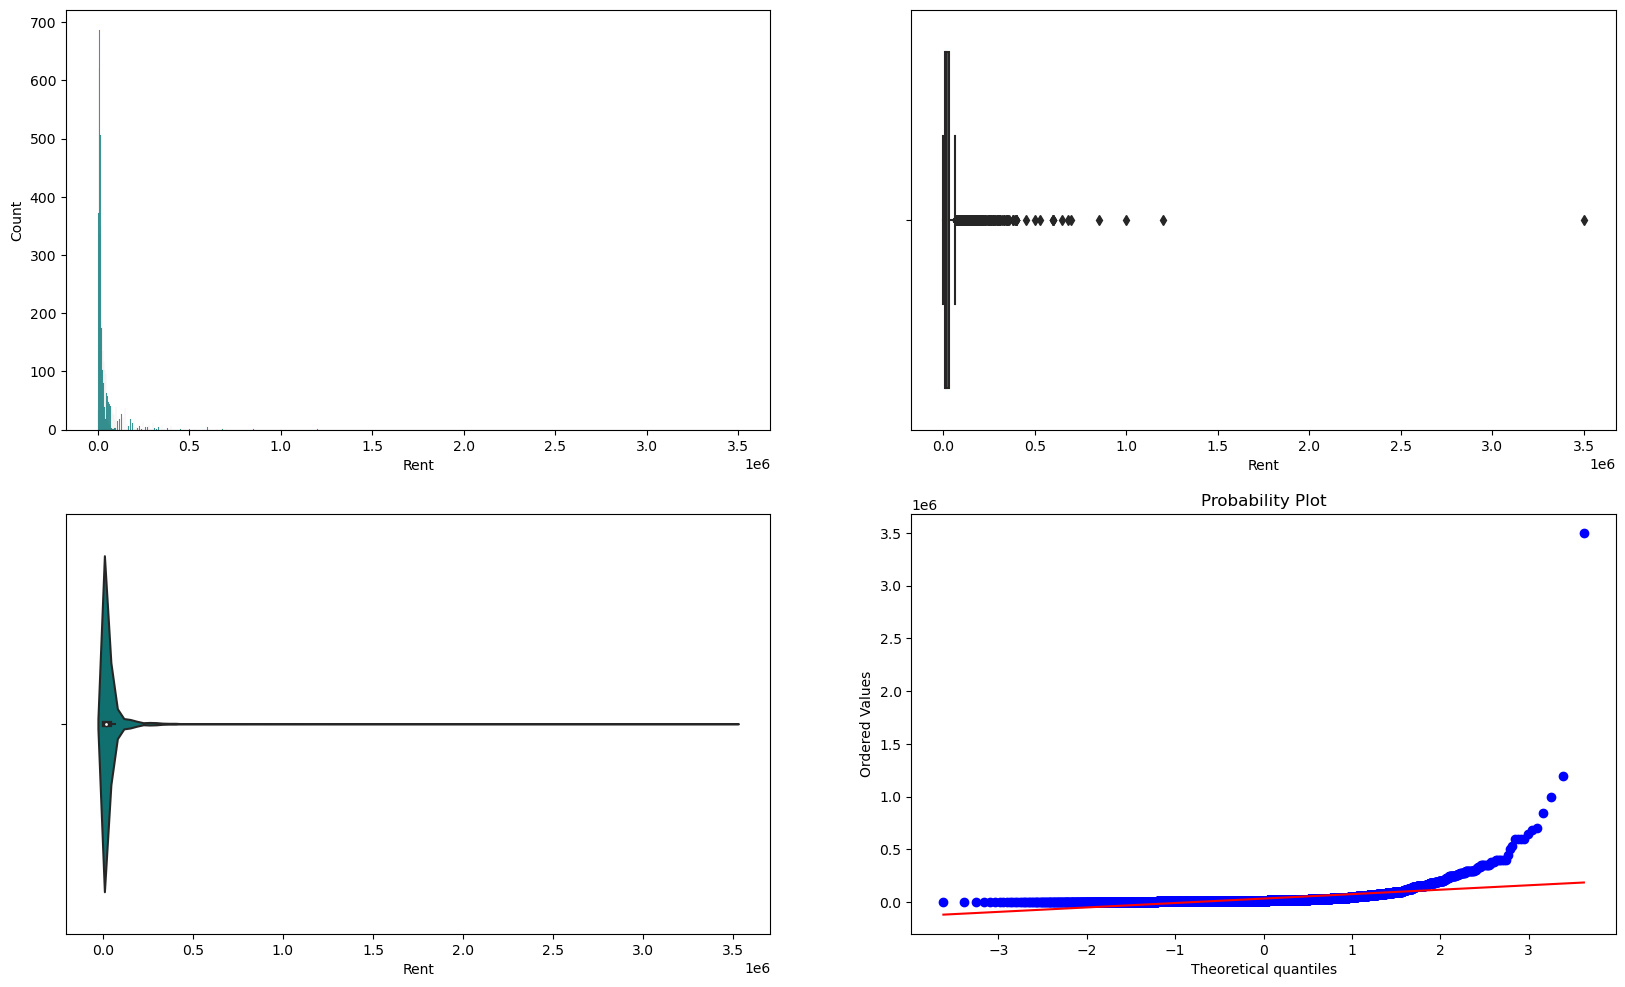

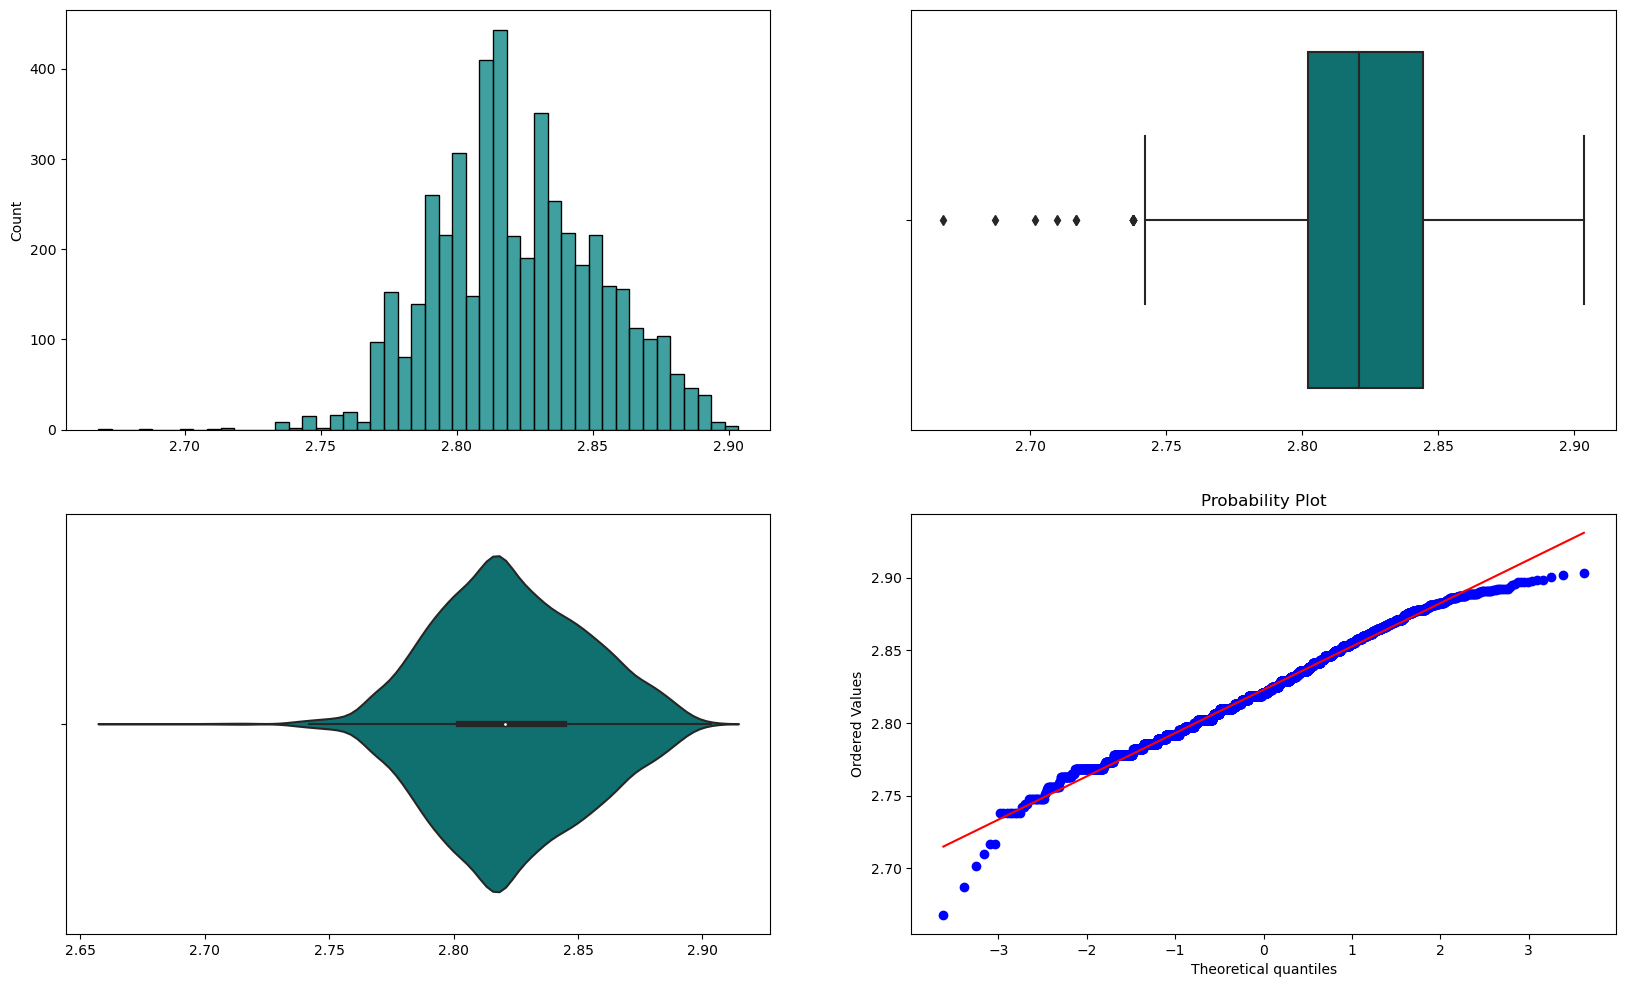

In [12]:
# Function for plotting the original distribution and probability plot
def plot_original_distribution(data, feature, color='teal'):
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    ax1 = sns.histplot(x=data[feature], color=color, ax=ax[0, 0])
    ax2 = sns.boxplot(x=data[feature], ax=ax[0, 1], color=color)
    ax3 = sns.violinplot(x=data[feature], ax=ax[1, 0], color=color)
    ax4 = probplot(data[feature], plot=pylab)
    pylab.show()

# Function for plotting the transformed distribution and probability plot
def plot_transformed_distribution(data, transformed_feature, color='teal'):
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    ax1 = sns.histplot(x=transformed_feature, color=color, ax=ax[0, 0])
    ax2 = sns.boxplot(x=transformed_feature, ax=ax[0, 1], color=color)
    ax3 = sns.violinplot(x=transformed_feature, ax=ax[1, 0], color=color)
    ax4 = probplot(transformed_feature, plot=pylab)
    pylab.show()

plot_original_distribution(data, 'Rent') # Original 'Rent' distribution and plots


max_rent = data['Rent'].max() # Removing rows with maximum 'Rent'
index_max_rent = data[data['Rent'] == max_rent].index
data = data.drop(index_max_rent)

bc_result = boxcox(data['Rent']) # Box-Cox transformation for 'Rent'
boxcox_rent = bc_result[0]
lam = bc_result[1]

plot_transformed_distribution(data, boxcox_rent) # Transformed 'Rent' distribution and plots

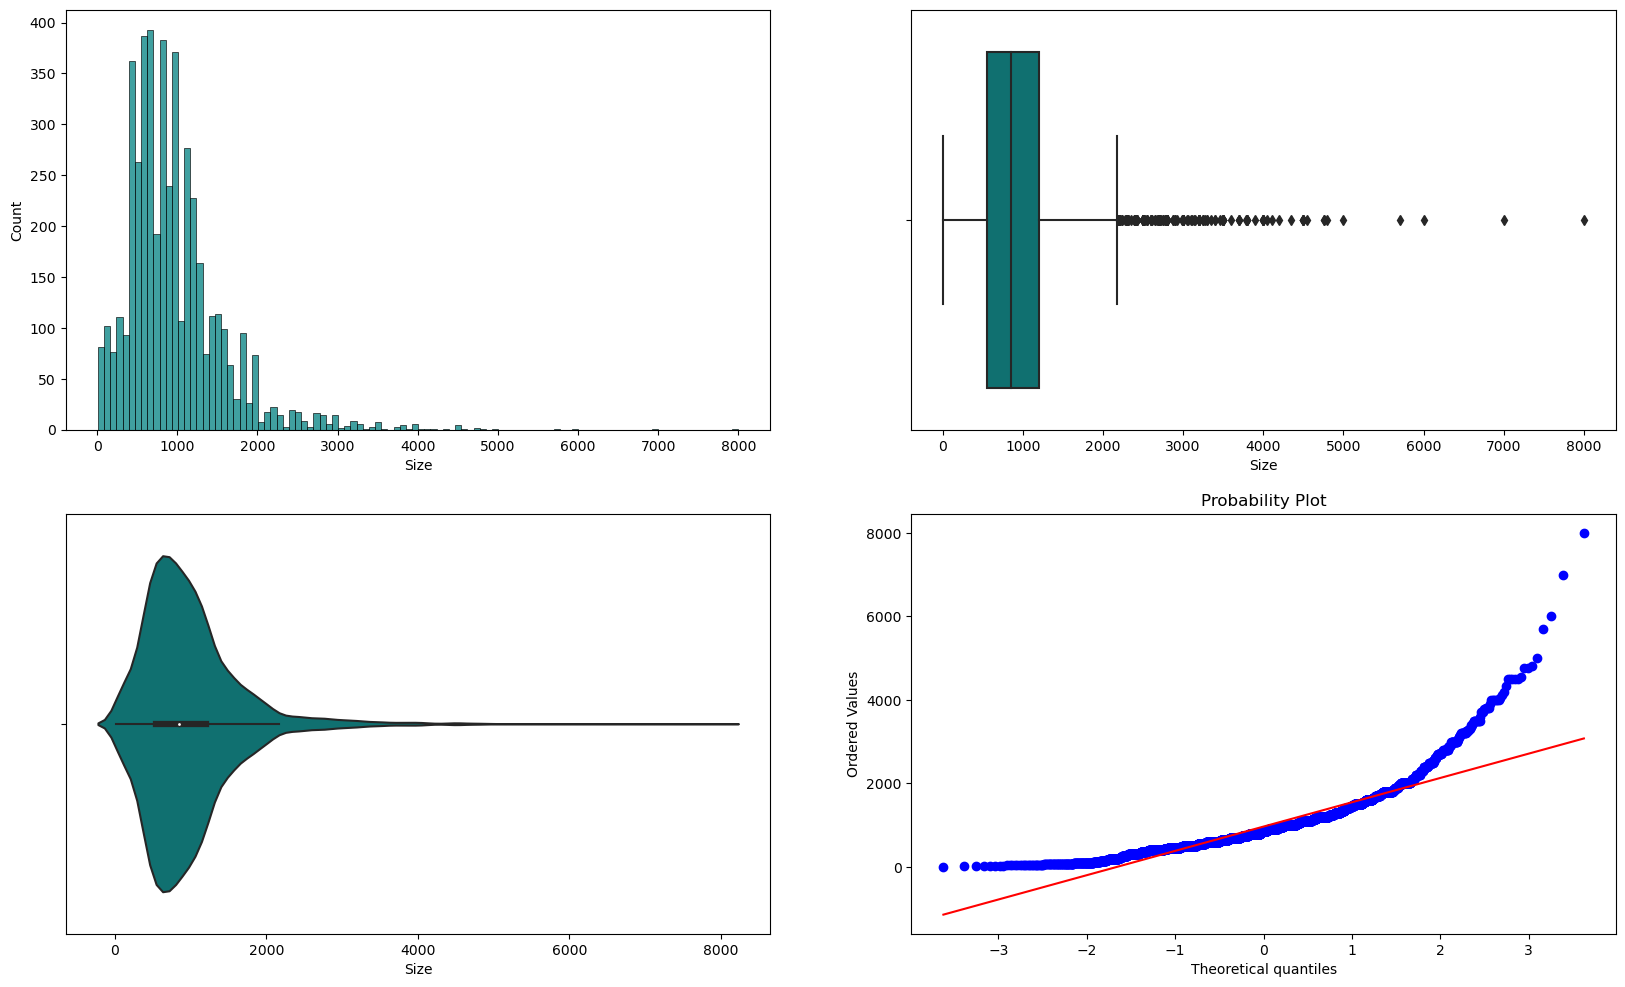

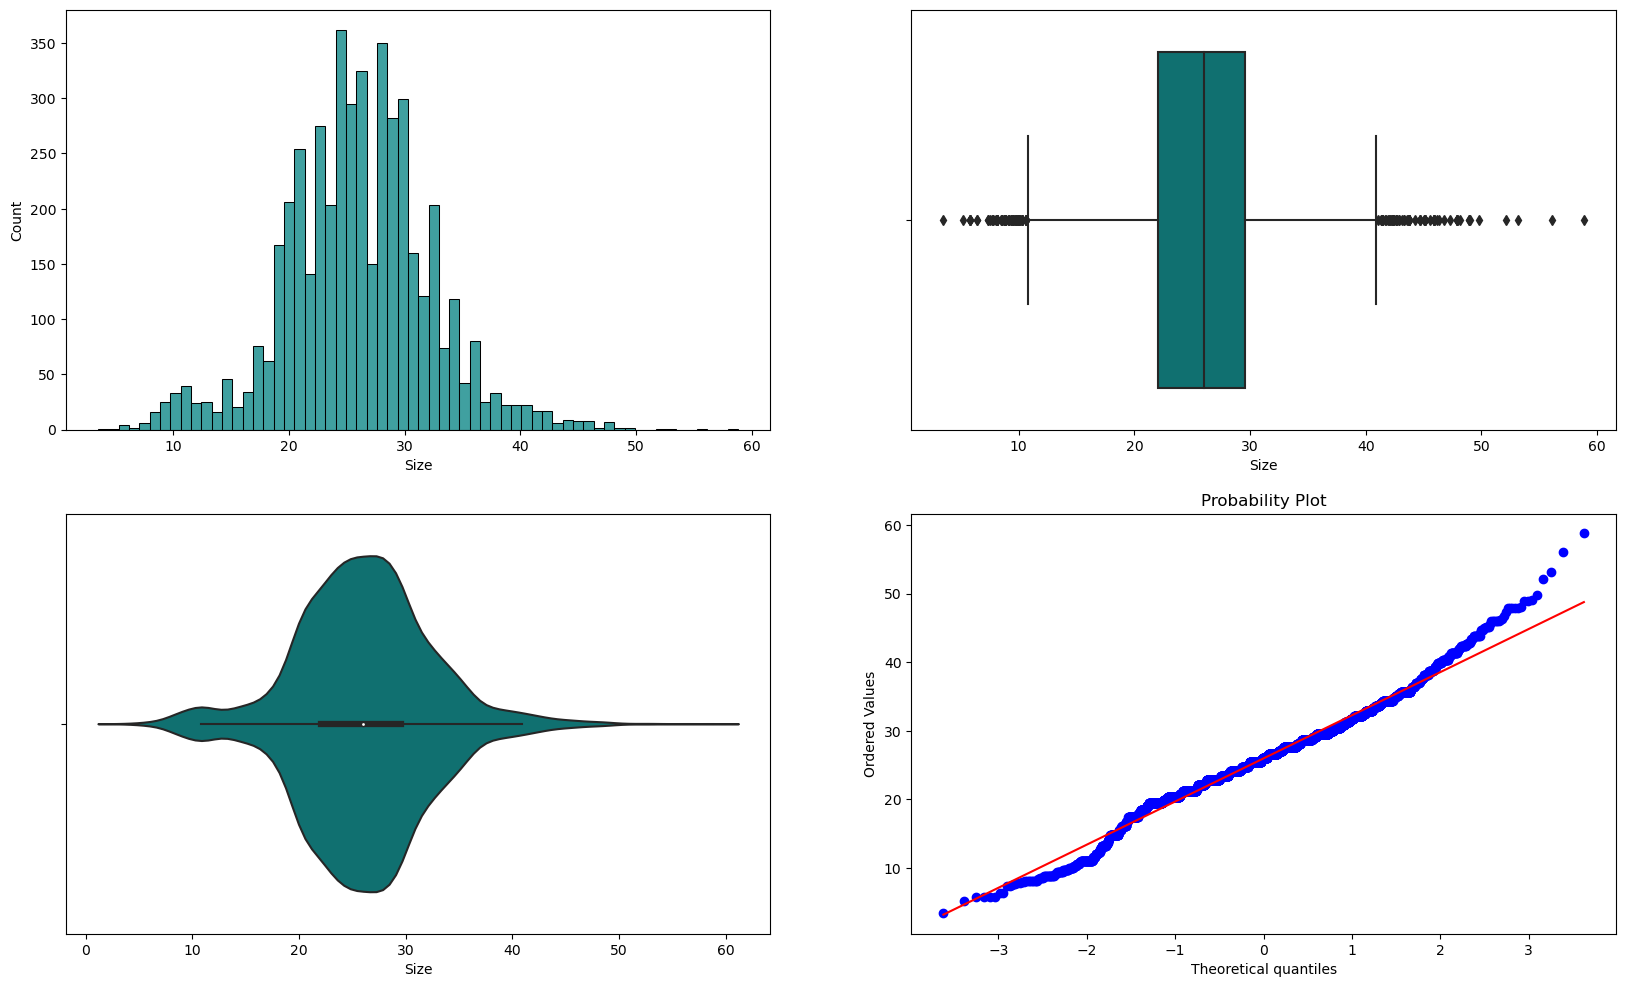

In [13]:
# Original 'Size' distribution and plots
plot_original_distribution(data, 'Size')

# Box-Cox transformation for 'Size'
data['Size'] = boxcox(data['Size'])[0]

# Transformed 'Size' distribution and plots
plot_transformed_distribution(data, data['Size'])

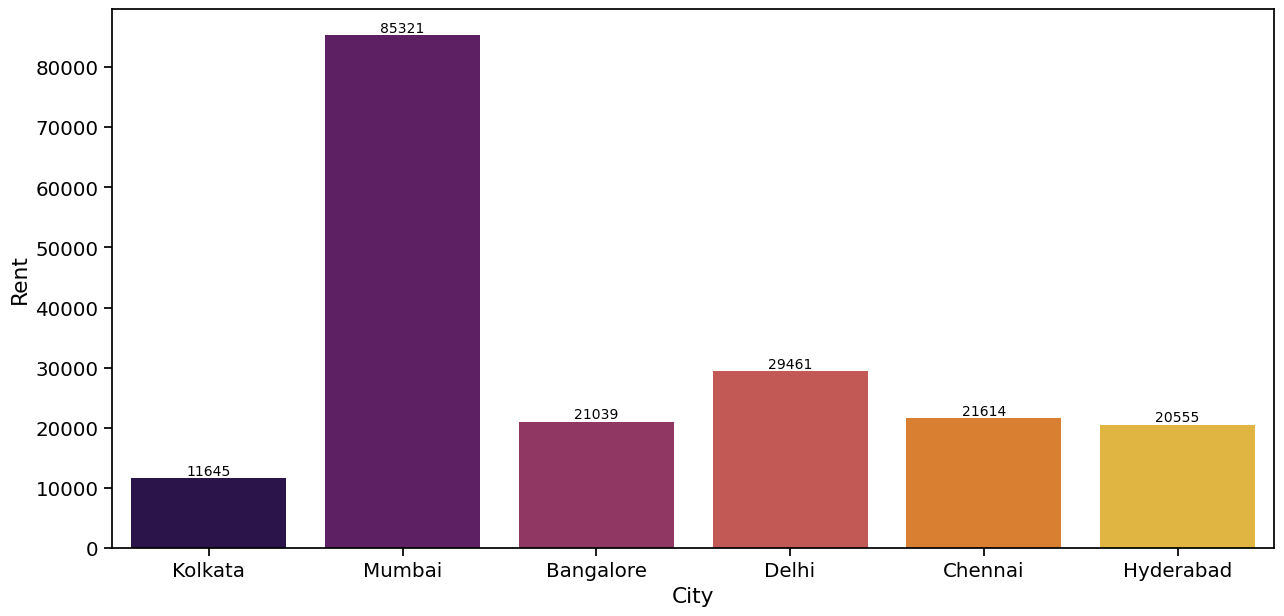

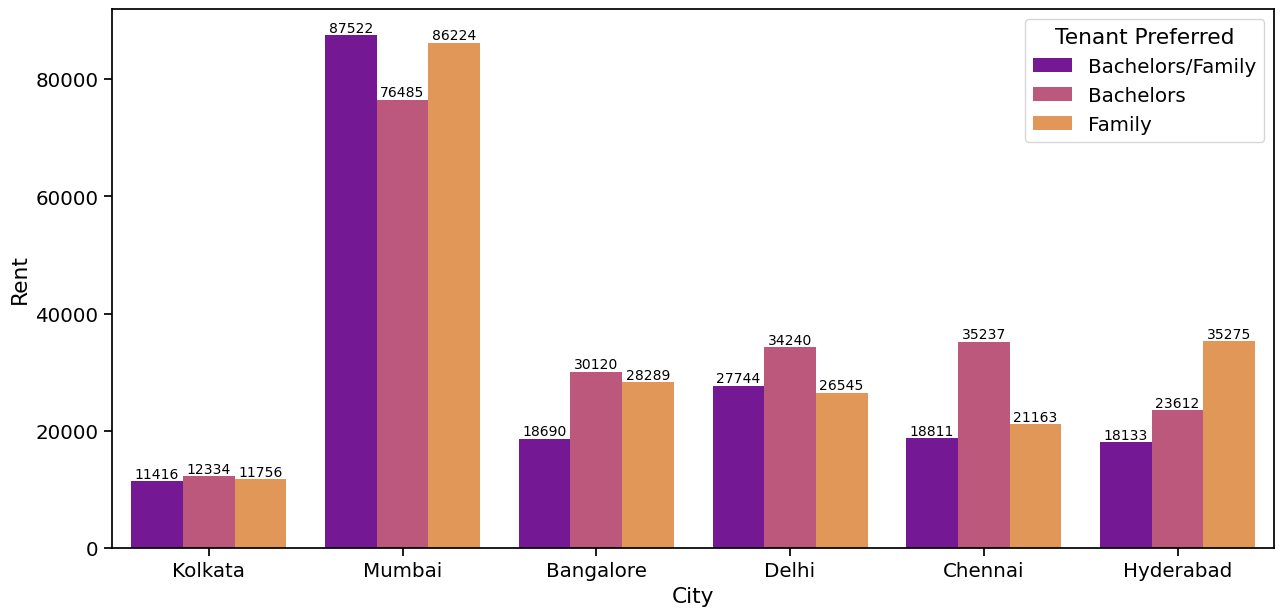

In [14]:
# Function for plotting bar plots
def plot_bar_plot(data, x_feature, y_feature, hue_feature=None):
    sns.set_context('notebook', font_scale=1.3)
    plt.figure(figsize=(15, 7))
    if hue_feature:
        ax = sns.barplot(x=data[x_feature], y=data[y_feature], hue=data[hue_feature], palette='plasma', ci=None)
    else:
        ax = sns.barplot(x=data[x_feature], y=data[y_feature], palette='inferno', ci=None)
    plt.ylabel(y_feature)
    for p in ax.patches:
        ax.annotate(
            int(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            color='black',
            fontsize=10 ) # Adjust the font size as needed

# Bar plot for 'Rent' grouped by 'City'
plot_bar_plot(data, 'City', 'Rent')

# Bar plot for 'Rent' grouped by 'City' and 'Tenant Preferred'
plot_bar_plot(data, 'City', 'Rent', 'Tenant Preferred')

# Filtering out rows containing "Built Area" in 'Area Type'
data = data[~data['Area Type'].str.contains("Built Area")]

In Chennai, Delhi and Bangalore, Bachelors usually have to pay more rent as compared to others

## Feature Engineering

In [15]:
# Assuming 'Floor' is a column in the DataFrame 'data'
data[['Floor Level', 'Total Floors']] = data['Floor'].str.split(' out of ', 1, expand=True)

# Mapping the 'Floor Level' column to numeric values
floor_level_mapping = {'Ground': 0, 'Lower Basement': -1, 'Upper Basement':-2}
data['Floor Level'] = data['Floor Level'].map(floor_level_mapping).fillna(data['Floor Level'])

# Dropping the original 'Floor' column
data.drop('Floor', axis=1, inplace=True)

# Dropping rows with missing values
data = data.dropna()

# Converting columns to integer type
data['Floor Level'] = data['Floor Level'].astype(int)
data['Total Floors'] = data['Total Floors'].astype(int)


In [16]:
print(data['Point of Contact'].value_counts())
print()
print(data['Area Type'].value_counts())

Contact Owner      3210
Contact Agent      1528
Contact Builder       1
Name: Point of Contact, dtype: int64

Super Area     2444
Carpet Area    2295
Name: Area Type, dtype: int64


In [17]:
data = data[~data['Point of Contact'].str.contains("Contact Builder")]

In [18]:
data['month posted'] = data['Posted On'].dt.month
data['day posted'] = data['Posted On'].dt.day
data['day of week posted'] = data['Posted On'].dt.day_of_week
data['quarter poster'] = data['Posted On'].dt.quarter

data.drop('Posted On', axis = 1, inplace= True)

## Encoding

In [19]:
# Remove duplicates
#data = data.drop_duplicates()

# Function for one-hot encoding
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first=True, prefix=column)
    data = pd.concat([data, encoded], axis=1)
    data = data.drop(column, axis=1)
    return data

# Drop 'Area Locality' column
data = data.drop('Area Locality', axis=1)

# Columns to one-hot encode
columns = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']

# Apply one-hot encoding
for col in columns:
    data = one_hot_encode(data, col)

# Prepare features (X) and target variable (y)
X = data.drop('Rent', axis=1)
y = data['Rent']

# Apply Box-Cox transformation to the target variable
y_boxcox, lambda_ = boxcox(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Print the shape of the training set
print(X_train.shape)

(3790, 20)


In [20]:
X_train

array([[-0.10365283,  0.00759936,  0.03557474, ..., -1.6391371 ,
         3.09145646,  0.68982367],
       [ 1.10139081,  0.9657864 ,  1.15914377, ..., -1.6391371 ,
        -0.32347213, -1.44964582],
       [ 1.10139081,  0.9657864 ,  1.15914377, ...,  0.6100771 ,
        -0.32347213,  0.68982367],
       ...,
       [ 1.10139081,  1.31450191,  1.15914377, ..., -1.6391371 ,
        -0.32347213,  0.68982367],
       [-1.30869647, -0.61175874, -1.08799428, ...,  0.6100771 ,
        -0.32347213,  0.68982367],
       [-1.30869647, -0.86796501,  0.03557474, ..., -1.6391371 ,
        -0.32347213, -1.44964582]])

In [21]:
y_train

array([2.84755437, 2.83992245, 2.8483429 , ..., 2.8431027 , 2.77951801,
       2.83752606])

In [22]:
X_test

array([[-1.30869647, -0.49514559, -1.08799428, ...,  0.6100771 ,
        -0.32347213,  0.68982367],
       [-1.30869647, -0.86796501, -1.08799428, ..., -1.6391371 ,
         3.09145646,  0.68982367],
       [-0.10365283,  0.18102882,  0.03557474, ..., -1.6391371 ,
        -0.32347213, -1.44964582],
       ...,
       [-0.10365283, -0.08421798,  0.03557474, ..., -1.6391371 ,
         3.09145646,  0.68982367],
       [-0.10365283, -0.01047242,  0.03557474, ...,  0.6100771 ,
        -0.32347213,  0.68982367],
       [ 2.30643445,  3.7214767 ,  2.28271279, ...,  0.6100771 ,
        -0.32347213, -1.44964582]])

In [23]:
y_test

array([2.81285513, 2.7835723 , 2.86140135, 2.78722851, 2.83021124,
       2.78722851, 2.86908582, 2.87237053, 2.82655897, 2.80358798,
       2.83021124, 2.77951801, 2.80567495, 2.8431027 , 2.83622918,
       2.83992245, 2.81992017, 2.81992017, 2.76985901, 2.83021124,
       2.80358798, 2.85843623, 2.79358749, 2.83752606, 2.82452196,
       2.86324897, 2.81121211, 2.77951801, 2.81441228, 2.84755437,
       2.80763271, 2.84755437, 2.87730338, 2.83340385, 2.82655897,
       2.81121211, 2.85122574, 2.84983522, 2.83752606, 2.83021124,
       2.86908582, 2.79896093, 2.83340385, 2.78722851, 2.83185854,
       2.80358798, 2.79358749, 2.79638025, 2.84499503, 2.82655897,
       2.78722851, 2.8431027 , 2.82844958, 2.86140135, 2.79638025,
       2.85122574, 2.86642896, 2.81992017, 2.78722851, 2.80763271,
       2.82344216, 2.85432811, 2.76985901, 2.83021124, 2.77951801,
       2.86642896, 2.81121211, 2.78722851, 2.77498327, 2.83992245,
       2.81863952, 2.81992017, 2.82655897, 2.81121211, 2.79055

In [24]:
data

,BHK,Rent,Size,Bathroom,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster,...,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Owner
0,2,10000,28.637810,2,0,2,5,18,2,2,...,0,0,0,1,0,0,1,1,0,1
1,2,20000,25.411055,1,1,3,5,13,4,2,...,0,0,0,1,0,1,0,1,0,1
2,2,17000,27.635366,1,1,3,5,16,0,2,...,0,0,0,1,0,1,0,1,0,1
3,2,10000,25.411055,1,1,2,7,4,0,3,...,0,0,0,1,0,0,1,1,0,1
4,2,7500,25.998850,1,1,2,5,9,0,2,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,15000,27.635366,2,3,5,5,18,2,2,...,0,0,1,0,0,1,0,1,0,1
4742,3,29000,35.719614,3,1,4,5,15,6,2,...,0,0,1,0,0,1,0,1,0,1
4743,3,35000,34.011370,3,3,5,7,10,6,3,...,0,0,1,0,0,1,0,1,0,0
4744,3,45000,32.132959,2,23,34,7,6,2,3,...,0,0,1,0,0,1,0,0,1,0


# Linear Regression

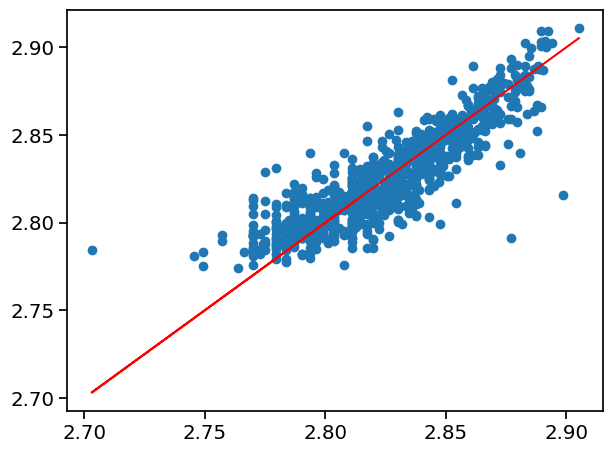

In [25]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test,'r')
plt.tight_layout()
plt.show()

In [26]:
House_Rent_Dataset = pd.DataFrame({'Actual': y_test, 
                                   'Predicted': y_pred})
House_Rent_Dataset

,Actual,Predicted
0,2.812855,2.803698
1,2.783572,2.777443
2,2.861401,2.864460
3,2.787229,2.791779
4,2.830211,2.829922
...,...,...
943,2.787229,2.794145
944,2.814412,2.807558
945,2.811212,2.814744
946,2.793587,2.806126


## Modelling

In [27]:
def train_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train)
        print(f'{name} trained')

def create_ann_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20),
        tf.keras.layers.Dense(60),
        tf.keras.layers.Dense(60),
        tf.keras.layers.Dense(60),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

def cross_validate_models(models, X_train, y_train, kf):
    results = {}
    for name, model in models.items():
        result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
        results[name] = result
    return results

def plot_rmse(results_df):
    plt.figure(figsize=(20, 6))
    sns.barplot(x=results_df.index, y=results_df['RMSE'], palette='winter')
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('RMSE of different models')

def ensemble_predictions(models, X_test, lam):
    return (
        0.20 * inv_boxcox(models['catboost'].predict(X_test), lam) +
        0.20 * inv_boxcox(models['xgboost'].predict(X_test), lam) +
        0.20 * inv_boxcox(models['random forest'].predict(X_test), lam) +
        0.20 * inv_boxcox(models['gradient boosting'].predict(X_test), lam)
    )

def evaluate_ensemble_predictions(y_test, lam, final_predictions):
    rmse = np.sqrt(mean_squared_error(inv_boxcox(y_test, lam), final_predictions))
    r_square = r2_score(inv_boxcox(y_test, lam), final_predictions)
    print(f'RMSE: {rmse}')
    print(f'R-square: {r_square}')

def plot_actual_vs_predicted(y_test, lam, final_predictions):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inv_boxcox(y_test, lam), y=final_predictions, color='#005b96')
    plt.xlabel('Actual rent',color='blue')
    plt.ylabel('Predicted rent',color='green')
    plt.show()

def plot_error_distribution(y_test, lam, final_predictions):
    plt.figure(figsize=(10, 6))
    sns.histplot(inv_boxcox(y_test, lam) - final_predictions, color='#005b96', kde=True)
    plt.xlabel('Error')
    plt.show()

# Train models
models = {
    'ridge': Ridge(),
    'xgboost': XGBRegressor(),
    'catboost': CatBoostRegressor(verbose=0),
    'gradient boosting': GradientBoostingRegressor(),
    'lasso': Lasso(),
    'random forest': RandomForestRegressor(),
    'bayesian ridge': BayesianRidge(),
    'support vector': SVR(),
    'knn': KNeighborsRegressor(n_neighbors=4)
}

train_models(models, X_train, y_train)

# Create and train ANN model
ann_model = create_ann_model()
ann_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

# Evaluate ANN model on the test set
RMSE_ann = ann_model.evaluate(X_test, y_test)[1]

# Cross-validate all models
kf = KFold(n_splits=10)
results = cross_validate_models(models, X_train, y_train, kf)

# Add ANN result to the dictionary
results['ANN'] = RMSE_ann


ridge trained
xgboost trained
catboost trained
gradient boosting trained
lasso trained


random forest trained
bayesian ridge trained
support vector trained
knn trained
Epoch 1/5
119/119 [==============================] - 0s 889us/step - loss: 2.0726 - rmse: 1.4397 - val_loss: 0.0027 - val_rmse: 0.0522
Epoch 2/5
119/119 [==============================] - 0s 444us/step - loss: 8.1373e-04 - rmse: 0.0285 - val_loss: 2.3038e-04 - val_rmse: 0.0152
Epoch 3/5
119/119 [==============================] - 0s 444us/step - loss: 2.7286e-04 - rmse: 0.0165 - val_loss: 2.7946e-04 - val_rmse: 0.0167
Epoch 4/5
119/119 [==============================] - 0s 434us/step - loss: 3.2396e-04 - rmse: 0.0180 - val_loss: 2.9269e-04 - val_rmse: 0.0171
Epoch 5/5
30/30 [==============================] - 0s 257us/step - loss: 3.6524e-04 - rmse: 0.0191


                       RMSE
support vector     0.044375
lasso              0.030126
ANN                0.019111
knn                0.015983
ridge              0.014395
bayesian ridge     0.014394
xgboost            0.014141
random forest      0.014072
gradient boosting  0.013569
catboost           0.013329
None


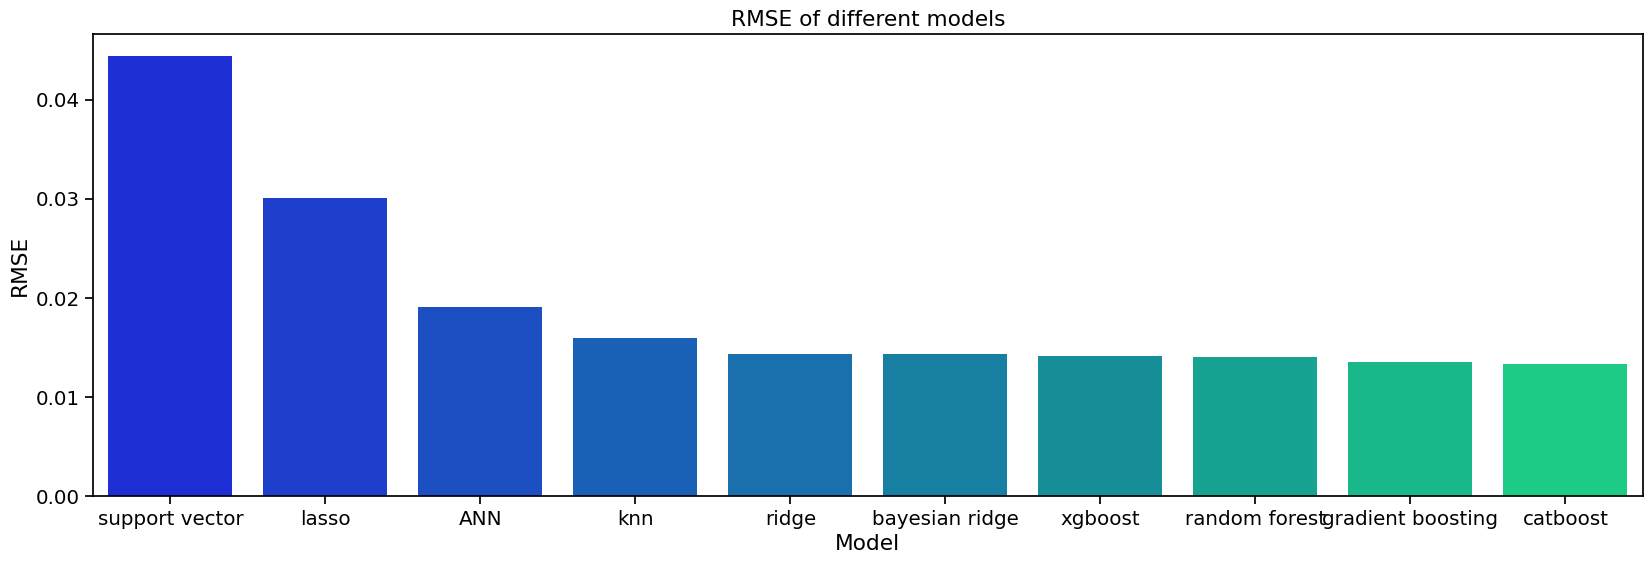

In [28]:
# Create a DataFrame to visualize results
results_df = pd.DataFrame(results, index=range(0, 1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
print(results_df)
# Plot RMSE of different models
print(plot_rmse(results_df))

RMSE: 50367.80708654215
R-square: 0.5514021578735733


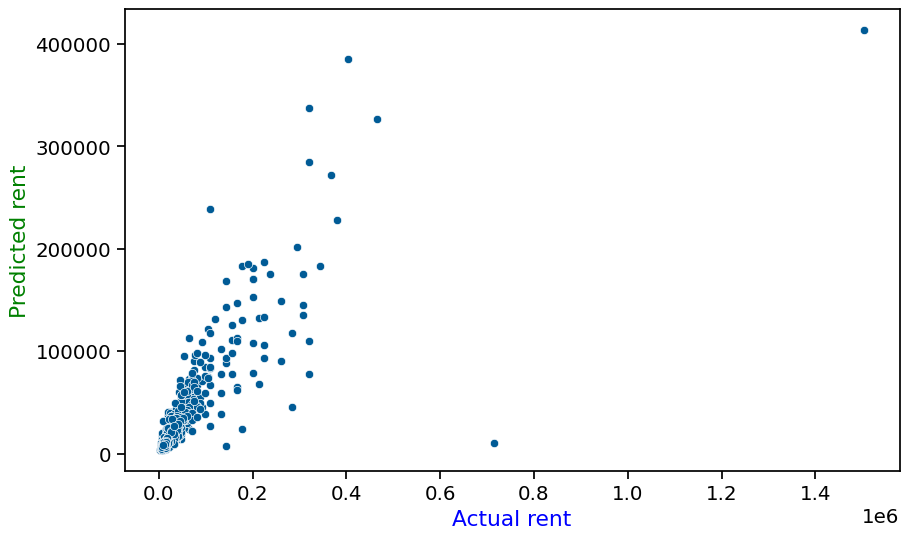

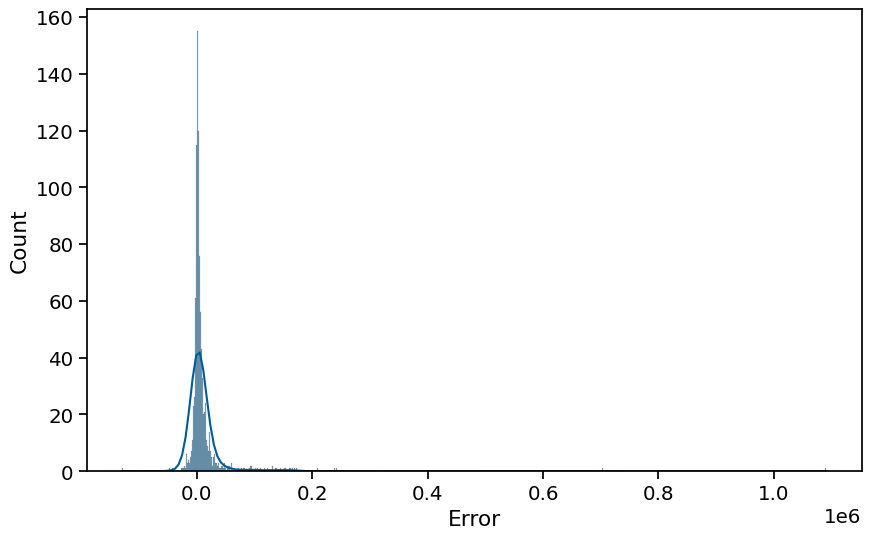

In [29]:
# Make final predictions using an ensemble of models
final_predictions = ensemble_predictions(models, X_test, lam)

# Evaluate ensemble predictions
evaluate_ensemble_predictions(y_test, lam, final_predictions)

# Plot actual vs predicted rent
plot_actual_vs_predicted(y_test, lam, final_predictions)

# Plot the distribution of errors
plot_error_distribution(y_test, lam, final_predictions)